# 트랜스포머 블록
- 인코더와 디코더 블록의 구조는 디테일에서 차이가 있을 뿐 본질적으로는 크게 다르지 않음.
- 멀티 헤드 어텐션, 피드포워드 뉴럴 네트워크, 잔차 연결 및 레이어 정규화 등 세 가지 구성 요소를 기본으로 사용.  
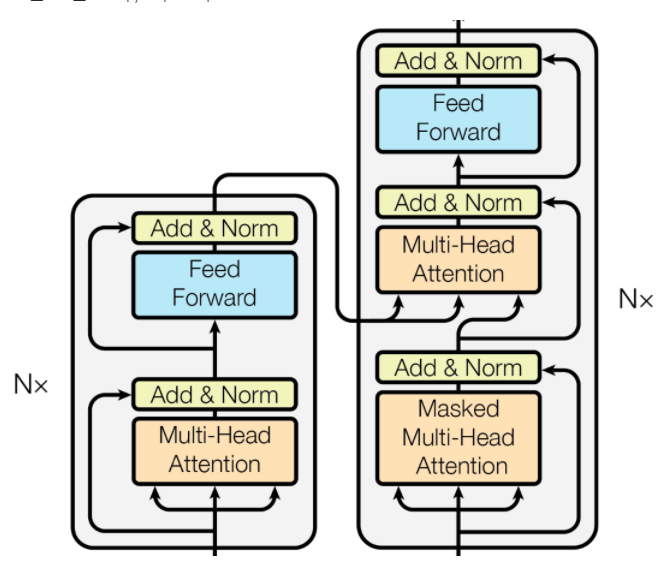

## FeedForward : 피드포워드 뉴럴네트워크
- 멀티 헤드 어텐션의 출력은 입력 단어들에 대응하는 벡터 시퀀스
- 벡터 각각을 피드포워드 뉴럴네트워크에 입력
- 피드포워드 뉴럴네트워크의 입력은 현재 블록의 멀티 헤드 어텐션의의 개별 출력 벡터가 된다.
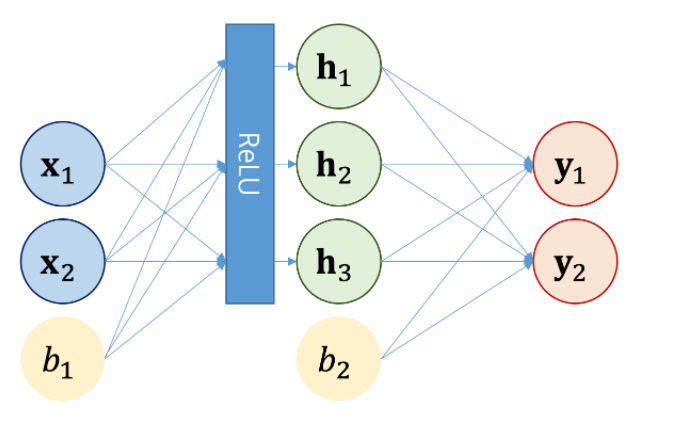

- 피드포워드 뉴럴네트워크 계산 예시 (1)

In [ ]:
import torch
x = torch.tensor([2,1])
w1 = torch.tensor([[3,2,-4],[2,-3,1]])
b1 = 1
w2 = torch.tensor([[-1, 1], [1,2], [3,1]])
b2 = -1

- 피드포워드 뉴럴네트워크 계산 예시 (2)

In [ ]:
h_preact = torch.matmul(x, w1) + b1
h = torch.nn.functional.relu(h_preact)
y = torch.matmul(h, w2) + b2

- 피드포워드 뉴럴네트워크 계산 예시

In [ ]:
print('h_preact:',h_preact)
print('h:', h)
print('y:', y)

h_preact: tensor([ 9,  2, -6])
h: tensor([9, 2, 0])
y: tensor([-8, 12])


- 트랜스포머에서는 은닉층의 뉴런 갯수(즉 은닉층의 차원수)를 입력층의 네 배로 설정
    - 예컨대 피드포워드 뉴럴네트워크의 입력 벡터가 768차원일 경우 은닉층은 2048차원까지 늘렸다가 출력층에서 이를 다시 768차원으로 변경

## Add : 잔차 연결
- Add는 잔차 연결(residual connection)을 가리킵니다. 잔차 연결이란 아래 그림 처럼 블록(block) 계산을 건너뛰는 경로를 하나 두는 것
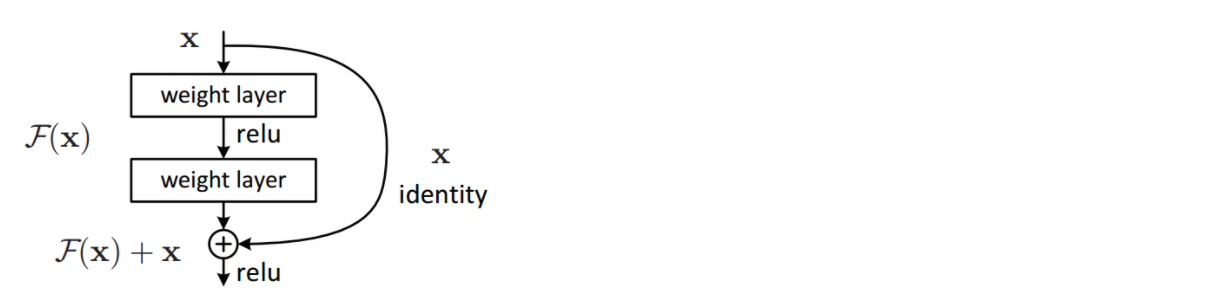

- 아래 그림 처럼 우측을 보면 잔차 연결을 두지 않았을 때는  f<sub>1</sub> , f<sub>2</sub> ,  f<sub>3</sub> 을 연속으로 수행하는 경로 한 가지만 존재하였으나, 잔차 연결을 블록마다 설정해둠으로써 모두 8가지의 새로운 경로가 생김.
- 모델이 다양한 관점에서 블록 계산 수행.   
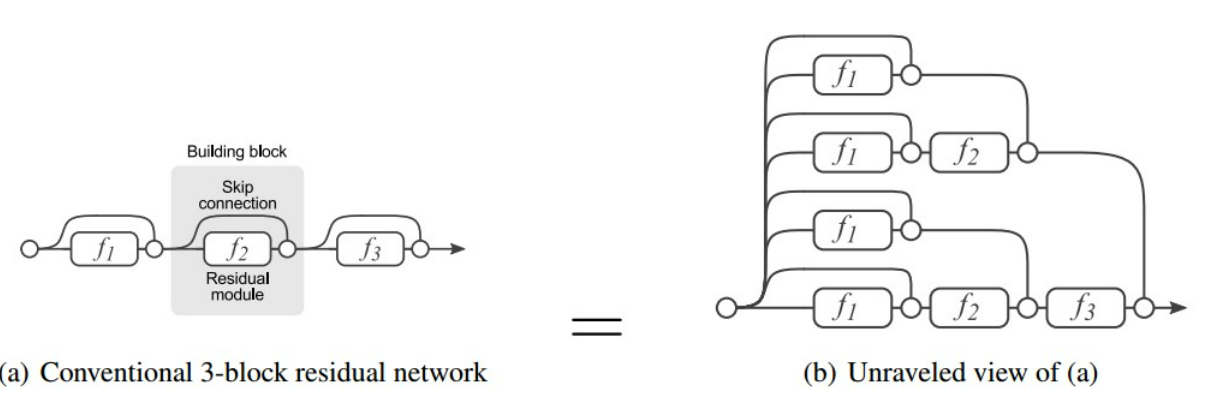

- 딥러닝 모델은 레이어가 많아지면 학습이 어려운 경향있다. 모델을 업데이트하기 위한 신호(그래디언트)가 전달되는 경로가 길어지기 때문.
- 잔차 연결은 모델 중간에 블록을 건너뛰는 경로를 설정함으로써 학습을 용이하게 하는 효과도 얻을 수 있음.

## Norm : 레이어 정규화
- 레이어 정규화(layer normalization)란 미니 배치의 인스턴스(X)별로 평균을 빼주고 표준편차로 나눠줘 정규화(normalization)을 수행하는 기법
- 레이어 정규화를 수행하면 학습이 안정되고 그 속도가 빨라지는 등의 효과가 있다.
- $β$(beta)와 $γ$(gamma)는 학습 과정에서 업데이트되는 가중치이며, $ϵ$(Epsilon)은 분모가 0이 되는 걸 방지하기 위해 더해주는 고정 값(보통 1e-5로 설정)   
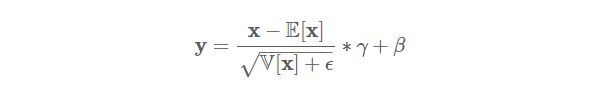

- 아래 그림은 배치 크기가 3인 경우 레이어 정규화 수행 과정의 일부를 나타낸다.
- 배치의 첫번째 데이터(x=[1,2,3])의 평균 $E[x]$)과 표준편차($\sqrt{V[x]}$)는 각각 2, 0.8164인데, 이를 위 수식으로 계산한다.
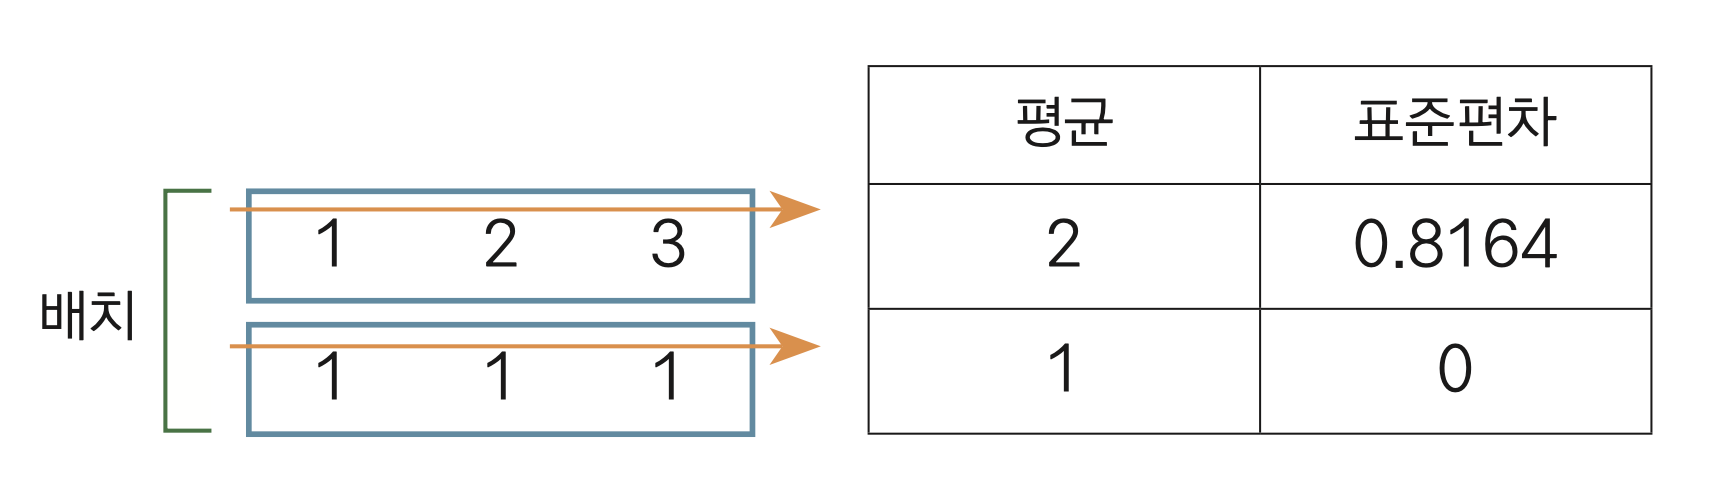
$$ y = \frac{x-2}{\sqrt{0.8164+ϵ}}*γ+β$$


- 레이어 정규화 예시

In [ ]:
import torch
input = torch.tensor([[1.0, 2.0, 3.0], [1.0, 1.0, 1.0]])
m = torch.nn.LayerNorm(input.shape[-1])
output = m(input)
print(output)

tensor([[-1.2247,  0.0000,  1.2247],
        [ 0.0000,  0.0000,  0.0000]], grad_fn=<NativeLayerNormBackward0>)


$$ y = \frac{x-E[x]}{\sqrt{V[X]+ϵ}}*γ+β$$
- 위 식을 보면 나눠준 결과에 $γ$를 곱하고 마지막으로 $β$를 더해주는 걸 알 수 있다.
- output을 출력한 결과 이 계산을 생략한 것 같이 보임.

In [ ]:
m.weight # γ 

Parameter containing:
tensor([1., 1., 1.], requires_grad=True)

In [ ]:
m.bias # β 

Parameter containing:
tensor([0., 0., 0.], requires_grad=True)

- 파이토치의 LayerNorm 객체는 이 두 값을 각각 1과 0으로 초기화
- 학습 초기 레이어 정규화 수행은 배치 인스턴스의 평균을 빼주고 표준편차로 나눠준 결과에 1을 곱하고 마지막으로 0을 더해준다

## 드롭아웃
- 딥러닝 모델은 그 표현력이 아주 좋아서 학습 데이터 그 자체를 외워버릴 염려가 있음.
- 이를 과적합(overfitting)이라고 합니다. 드롭아웃(dropout)은 이러한 과적합 현상을 방지하고자 뉴런의 일부를 확률적으로 0으로 대치하여 계산에서 제외하는 기법.
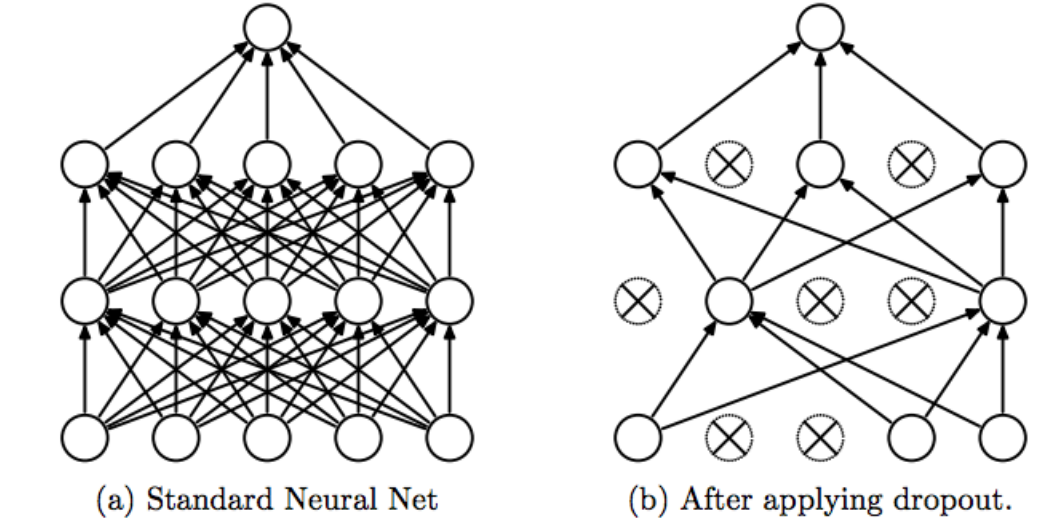

In [ ]:
import torch
m = torch.nn.Dropout(p=0.2)
input = torch.randn(1, 10)
output = m(input)

In [ ]:
print('input: ',input)
print('output: ',output)

input:  tensor([[-0.3292, -0.2190, -0.6544, -0.4307, -0.9221,  0.5400, -0.1759, -1.0966,
          1.8565, -0.1030]])
output:  tensor([[-0.4115, -0.2738, -0.8180, -0.0000, -1.1527,  0.0000, -0.2199, -1.3707,
          0.0000, -0.1288]])


- 안정적인 학습을 위해 각 요솟값에  $1/(1−p)$를 곱하는 역할도 수행
- 드롭아웃 비율은 10%(p=0.1)로 설정하는 것이 일반적